In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install numpy pandas matplotlib collections

  Using cached matplotlib-3.10.7-cp312-cp312-win_amd64.whl.metadata (11 kB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections


In [3]:
!pip install matplotlib

  Using cached matplotlib-3.10.7-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp312-cp312-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp312-cp312-win_amd64.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.7-cp312-cp312-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp312-cp312-win_amd64.whl (226 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.60.1-cp312-cp312-win_amd64.whl (2.3 MB)
Using cached kiwisolver-1.4.9-cp312-cp312-win_amd64.whl (73 kB)
Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)

   ---------------------------------------- 0/6 [pyparsing]
   ---------------------------------------- 0/6 [pyparsing]
   ------ --------------------------------- 1/6 [kiwisolver]
   ------------- -

In [2]:
import pandas as pd
import json
from collections import Counter
import matplotlib.pyplot as plt

# 1.1 Load JSON data
def load_amazon_reviews(file_path):
    
    chunks = pd.read_json(file_path, lines=True, chunksize=1000000)
    for i, chunk in enumerate(chunks):
        chunk.to_parquet(f"{file_path}_{i}.parquet")

    # Combine parquet files next time
    df = pd.concat([pd.read_parquet(f"{file_path}_{i}.parquet") for i in range(5)])
    return df

books_df = load_amazon_reviews('Books_50lakh.jsonl')
movies_df = load_amazon_reviews('movies_50lakh.jsonl')

print(f"Books dataset: {len(books_df)} reviews")
print(f"Movies dataset: {len(movies_df)} reviews")

Books dataset: 5000000 reviews
Movies dataset: 5000000 reviews


In [ ]:

# 1.2 Initial exploration
def explore_dataset(df, domain_name):
    
    print(f"\n{'='*50}")
    print(f"{domain_name} Dataset Statistics")
    print(f"{'='*50}")
    
    print(f"Total reviews: {len(df)}")
    print(f"Unique users: {df['user_id'].nunique()}")
    print(f"Unique items: {df['asin'].nunique()}")
    print(f"Date range: {pd.to_datetime(df['timestamp'], unit='ms').min()} to {pd.to_datetime(df['timestamp'], unit='ms').max()}")
    
    print(f"\nRating distribution:")
    print(df['rating'].value_counts().sort_index())
    
    print(f"\nReview text length:")
    df['text_length'] = df['text'].str.len()
    print(df['text_length'].describe())
    
    print(f"\nVerified purchase rate: {df['verified_purchase'].mean():.2%}")
    
    return df

books_df = explore_dataset(books_df, "Books")
movies_df = explore_dataset(movies_df, "Movies")



Books Dataset Statistics
Total reviews: 5000000
Unique users: 974915
Unique items: 1541824
Date range: 1996-12-17 04:27:10 to 2023-03-30 19:02:34.370000

Rating distribution:
rating
0          4
1     182306
2     186922
3     402082
4     846822
5    3381864
Name: count, dtype: int64

Review text length:
count    5.000000e+06
mean     4.338194e+02
std      7.699124e+02
min      0.000000e+00
25%      6.300000e+01
50%      1.650000e+02
75%      4.420000e+02
max      3.260100e+04
Name: text_length, dtype: float64

Verified purchase rate: 73.16%

Movies Dataset Statistics
Total reviews: 5000000
Unique users: 1052914
Unique items: 452677
Date range: 1997-11-14 03:36:49 to 2023-04-02 07:23:54.275000

Rating distribution:
rating
1     346285
2     235522
3     417821
4     806243
5    3194129
Name: count, dtype: int64

Review text length:
count    5.000000e+06
mean     2.635592e+02
std      6.282791e+02
min      0.000000e+00
25%      3.100000e+01
50%      9.600000e+01
75%      2.290000e+02


In [ ]:
def find_common_users(books_df, movies_df):
    
    books_users = set(books_df['user_id'].unique())
    movies_users = set(movies_df['user_id'].unique())
    
    common_users = books_users.intersection(movies_users)
    
    print(f"\n{'='*50}")
    print("Cross-Domain User Analysis")
    print(f"{'='*50}")
    print(f"Books-only users: {len(books_users - common_users):,}")
    print(f"Movies-only users: {len(movies_users - common_users):,}")
    print(f"Common users (U_c): {len(common_users):,}")
    print(f"Common users ratio: {len(common_users)/len(books_users):.2%}")
    
    return list(common_users)

common_users = find_common_users(books_df, movies_df)

# Keep only common users for cross-domain training
books_df_common = books_df[books_df['user_id'].isin(common_users)].copy()
movies_df_common = movies_df[movies_df['user_id'].isin(common_users)].copy()

print(f"\nFiltered Books reviews: {len(books_df_common):,}")
print(f"Filtered Movies reviews: {len(movies_df_common):,}")


Cross-Domain User Analysis
Books-only users: 555,651
Movies-only users: 633,650
Common users (U_c): 419,264
Common users ratio: 43.01%

Filtered Books reviews: 3,090,111
Filtered Movies reviews: 2,582,961


In [ ]:
def analyze_review_distribution(books_df_common, movies_df_common):
    
    print("\n" + "="*60)
    print("DATA DISTRIBUTION ANALYSIS")
    print("="*60)
    
    # Books analysis
    books_user_counts = books_df_common['user_id'].value_counts()
    books_item_counts = books_df_common['asin'].value_counts()
    
    print("\n BOOKS DOMAIN:")
    print(f"Total reviews: {len(books_df_common):,}")
    print(f"Unique users: {books_df_common['user_id'].nunique():,}")
    print(f"Unique items: {books_df_common['asin'].nunique():,}")
    print(f"\nReviews per USER:")
    print(f"  Mean: {books_user_counts.mean():.2f}")
    print(f"  Median: {books_user_counts.median():.0f}")
    print(f"  Users with ≥5 reviews: {(books_user_counts >= 5).sum():,}")
    print(f"  Users with ≥10 reviews: {(books_user_counts >= 10).sum():,}")
    print(f"  Users with ≥15 reviews: {(books_user_counts >= 15).sum():,}")
    print(f"  Users with ≥25 reviews: {(books_user_counts >= 25).sum():,}")
    
    print(f"\nReviews per ITEM:")
    print(f"  Mean: {books_item_counts.mean():.2f}")
    print(f"  Median: {books_item_counts.median():.0f}")
    print(f"  Items with ≥5 reviews: {(books_item_counts >= 5).sum():,}")
    print(f"  Items with ≥10 reviews: {(books_item_counts >= 10).sum():,}")
    print(f"  Items with ≥15 reviews: {(books_item_counts >= 15).sum():,}")
    print(f"  Items with ≥25 reviews: {(books_item_counts >= 25).sum():,}")
    
    # Movies analysis
    movies_user_counts = movies_df_common['user_id'].value_counts()
    movies_item_counts = movies_df_common['asin'].value_counts()
    
    print("\n MOVIES DOMAIN:")
    print(f"Total reviews: {len(movies_df_common):,}")
    print(f"Unique users: {movies_df_common['user_id'].nunique():,}")
    print(f"Unique items: {movies_df_common['asin'].nunique():,}")
    print(f"\nReviews per USER:")
    print(f"  Mean: {movies_user_counts.mean():.2f}")
    print(f"  Median: {movies_user_counts.median():.0f}")
    print(f"  Users with ≥5 reviews: {(movies_user_counts >= 5).sum():,}")
    print(f"  Users with ≥10 reviews: {(movies_user_counts >= 10).sum():,}")
    print(f"  Users with ≥15 reviews: {(movies_user_counts >= 15).sum():,}")
    print(f"  Users with ≥25 reviews: {(movies_user_counts >= 25).sum():,}")
    
    print(f"\nReviews per ITEM:")
    print(f"  Mean: {movies_item_counts.mean():.2f}")
    print(f"  Median: {movies_item_counts.median():.0f}")
    print(f"  Items with ≥5 reviews: {(movies_item_counts >= 5).sum():,}")
    print(f"  Items with ≥10 reviews: {(movies_item_counts >= 10).sum():,}")
    print(f"  Items with ≥15 reviews: {(movies_item_counts >= 15).sum():,}")
    print(f"  Items with ≥25 reviews: {(movies_item_counts >= 25).sum():,}")

# Run diagnosis
analyze_review_distribution(books_df_common, movies_df_common)


DATA DISTRIBUTION ANALYSIS

📚 BOOKS DOMAIN:
Total reviews: 3,090,111
Unique users: 419,264
Unique items: 1,151,498

Reviews per USER:
  Mean: 7.37
  Median: 3
  Users with ≥5 reviews: 147,250
  Users with ≥10 reviews: 70,592
  Users with ≥15 reviews: 42,350
  Users with ≥25 reviews: 20,598

Reviews per ITEM:
  Mean: 2.68
  Median: 1
  Items with ≥5 reviews: 117,831
  Items with ≥10 reviews: 44,872
  Items with ≥15 reviews: 24,278
  Items with ≥25 reviews: 10,874

🎬 MOVIES DOMAIN:
Total reviews: 2,582,961
Unique users: 419,264
Unique items: 350,644

Reviews per USER:
  Mean: 6.16
  Median: 2
  Users with ≥5 reviews: 124,427
  Users with ≥10 reviews: 58,285
  Users with ≥15 reviews: 34,937
  Users with ≥25 reviews: 17,143

Reviews per ITEM:
  Mean: 7.37
  Median: 2
  Items with ≥5 reviews: 91,622
  Items with ≥10 reviews: 49,661
  Items with ≥15 reviews: 33,712
  Items with ≥25 reviews: 19,219



STARTING STEP 3: FILTERING WITH OPTIMAL THRESHOLD

TESTING MULTIPLE THRESHOLDS

######################################################################
# TESTING: U3_I3 (Very Lenient)
######################################################################

FILTERING Books (U3_I3 (Very Lenient)) DATASET
Threshold: U3_I3
Initial size: 3,090,111 reviews
Initial users: 419,264
Initial items: 1,151,498

Iteration 1:
  Reviews: 1,794,430 (lost 1,295,681)
  Users: 218,315 (lost 200,949)
  Items: 215,935 (lost 935,563)

Iteration 2:
  Reviews: 1,685,109 (lost 109,321)
  Users: 165,984 (lost 52,331)
  Items: 203,369 (lost 12,566)

Iteration 3:
  Reviews: 1,679,059 (lost 6,050)
  Users: 163,629 (lost 2,355)
  Items: 202,656 (lost 713)

Iteration 4:
  Reviews: 1,678,717 (lost 342)
  Users: 163,499 (lost 130)
  Items: 202,615 (lost 41)

✅ Minimal change detected. Stopping early.

FINAL RESULTS FOR Books (U3_I3 (Very Lenient))
Reviews: 1,678,717
Users: 163,499
Items: 202,615

Per-user statistics:
  

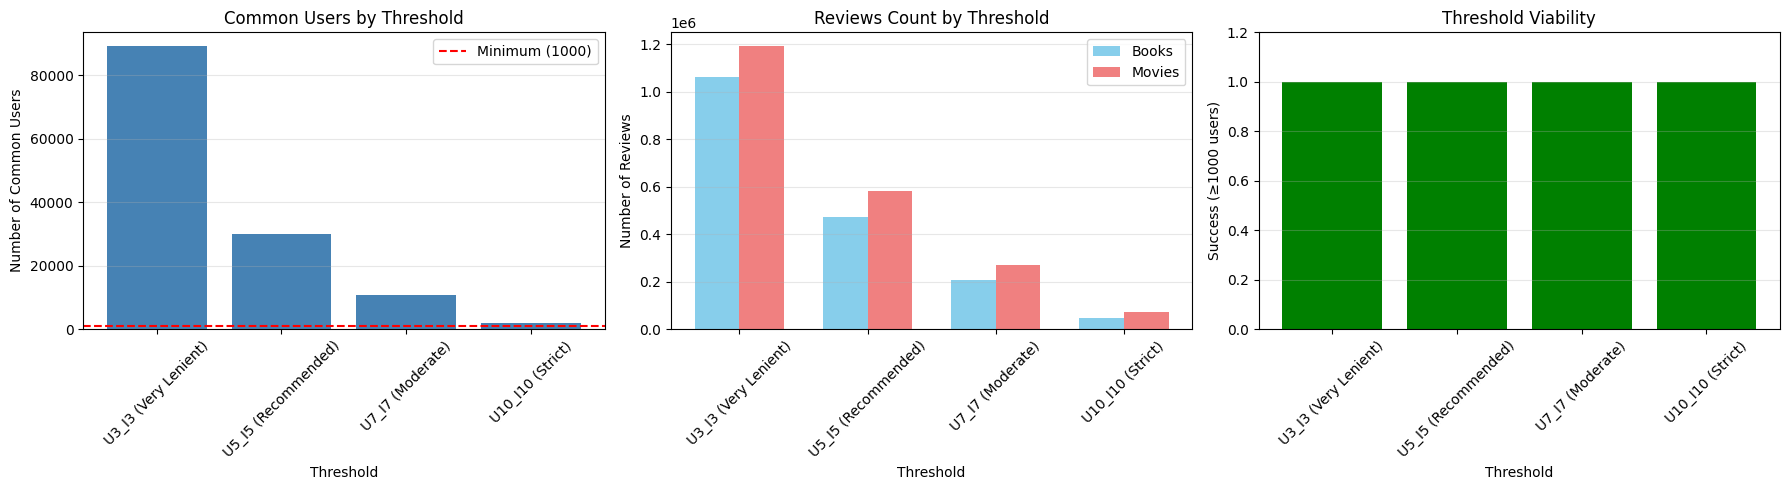


✅ Visualization saved as 'threshold_comparison.png'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gc

# STEP 3: FILTERING WITH MULTIPLE THRESHOLD OPTIONS


def filter_by_count_detailed(df, min_user_reviews, min_item_reviews, domain_name="", max_iterations=20):
    
    print(f"\n{'='*70}")
    print(f"FILTERING {domain_name} DATASET")
    print(f"{'='*70}")
    print(f"Threshold: U{min_user_reviews}_I{min_item_reviews}")
    print(f"Initial size: {len(df):,} reviews")
    print(f"Initial users: {df['user_id'].nunique():,}")
    print(f"Initial items: {df['asin'].nunique():,}")
    
    # Track statistics per iteration
    iteration_stats = []
    
    for iteration in range(max_iterations):
        prev_size = len(df)
        prev_users = df['user_id'].nunique()
        prev_items = df['asin'].nunique()
        
        #FILTER USERS
        user_counts = df['user_id'].value_counts()
        valid_users = user_counts[user_counts >= min_user_reviews].index
        df = df[df['user_id'].isin(valid_users)]
        
        users_after_user_filter = df['user_id'].nunique()
        
        # FILTER ITEMS
        item_counts = df['asin'].value_counts()
        valid_items = item_counts[item_counts >= min_item_reviews].index
        df = df[df['asin'].isin(valid_items)]
        
        curr_size = len(df)
        curr_users = df['user_id'].nunique()
        curr_items = df['asin'].nunique()
        
        # Log iteration stats
        stats = {
            'iteration': iteration + 1,
            'reviews': curr_size,
            'users': curr_users,
            'items': curr_items,
            'reviews_lost': prev_size - curr_size,
            'users_lost': prev_users - curr_users,
            'items_lost': prev_items - curr_items,
        }
        iteration_stats.append(stats)
        
        # Print progress
        print(f"\nIteration {iteration+1}:")
        print(f"  Reviews: {curr_size:,} (lost {stats['reviews_lost']:,})")
        print(f"  Users: {curr_users:,} (lost {stats['users_lost']:,})")
        print(f"  Items: {curr_items:,} (lost {stats['items_lost']:,})")
        
        # ===== CHECK CONVERGENCE =====
        if curr_size == prev_size:
            print(f"\n Converged after {iteration+1} iterations!")
            break
        
        if curr_size == 0:
            print(f"\n Data collapsed to 0! Threshold too strict.")
            break
        
        # Stop if losing too little (< 0.1%)
        if prev_size > 0 and (prev_size - curr_size) / prev_size < 0.001:
            print(f"\n Minimal change detected. Stopping early.")
            break
    
    # FINAL STATISTICS 
    if len(df) > 0:
        print(f"\n{'='*70}")
        print(f"FINAL RESULTS FOR {domain_name}")
        print(f"{'='*70}")
        print(f"Reviews: {len(df):,}")
        print(f"Users: {df['user_id'].nunique():,}")
        print(f"Items: {df['asin'].nunique():,}")
        
        user_counts = df['user_id'].value_counts()
        item_counts = df['asin'].value_counts()
        
        print(f"\nPer-user statistics:")
        print(f"  Min reviews: {user_counts.min()}")
        print(f"  Max reviews: {user_counts.max()}")
        print(f"  Mean reviews: {user_counts.mean():.2f}")
        print(f"  Median reviews: {user_counts.median():.0f}")
        
        print(f"\nPer-item statistics:")
        print(f"  Min reviews: {item_counts.min()}")
        print(f"  Max reviews: {item_counts.max()}")
        print(f"  Mean reviews: {item_counts.mean():.2f}")
        print(f"  Median reviews: {item_counts.median():.0f}")
        
        retention_rate = (len(df) / iteration_stats[0]['reviews']) * 100
        print(f"\nRetention rate: {retention_rate:.2f}%")
    else:
        print(f"\n NO DATA REMAINING!")
    
    return df, iteration_stats


# TRY MULTIPLE THRESHOLDS


def try_multiple_thresholds(books_df_common, movies_df_common):
    """
    Try different thresholds and compare results
    """
    print("\n" + "="*70)
    print("TESTING MULTIPLE THRESHOLDS")
    print("="*70)
    
    thresholds = [
        (3, 3, "U3_I3 (Very Lenient)"),
        (5, 5, "U5_I5 (Recommended)"),
        (7, 7, "U7_I7 (Moderate)"),
        (10, 10, "U10_I10 (Strict)"),
    ]
    
    results = []
    
    for min_user, min_item, label in thresholds:
        print(f"\n{'#'*70}")
        print(f"# TESTING: {label}")
        print(f"{'#'*70}")
        
        # Books
        books_test = books_df_common.copy()
        books_filtered, books_stats = filter_by_count_detailed(
            books_test, min_user, min_item, f"Books ({label})"
        )
        
        # Movies
        movies_test = movies_df_common.copy()
        movies_filtered, movies_stats = filter_by_count_detailed(
            movies_test, min_user, min_item, f"Movies ({label})"
        )
        
        # Check common users after filtering
        if len(books_filtered) > 0 and len(movies_filtered) > 0:
            books_users = set(books_filtered['user_id'].unique())
            movies_users = set(movies_filtered['user_id'].unique())
            common_users_final = books_users.intersection(movies_users)
            
            print(f"\n{'='*70}")
            print(f"CROSS-DOMAIN ANALYSIS: {label}")
            print(f"{'='*70}")
            print(f"Common users after filtering: {len(common_users_final):,}")
            print(f"Books reviews: {len(books_filtered):,}")
            print(f"Movies reviews: {len(movies_filtered):,}")
            
            # Re-filter to keep only common users
            books_common_final = books_filtered[books_filtered['user_id'].isin(common_users_final)]
            movies_common_final = movies_filtered[movies_filtered['user_id'].isin(common_users_final)]
            
            print(f"\nAfter keeping only common users:")
            print(f"Books reviews: {len(books_common_final):,}")
            print(f"Movies reviews: {len(movies_common_final):,}")
            
            results.append({
                'threshold': label,
                'min_user': min_user,
                'min_item': min_item,
                'common_users': len(common_users_final),
                'books_reviews': len(books_common_final),
                'movies_reviews': len(movies_common_final),
                'books_df': books_common_final,
                'movies_df': movies_common_final,
                'success': len(common_users_final) >= 1000  
            })
        else:
            print(f"\n {label}: Data collapsed to 0!")
            results.append({
                'threshold': label,
                'min_user': min_user,
                'min_item': min_item,
                'common_users': 0,
                'books_reviews': 0,
                'movies_reviews': 0,
                'books_df': pd.DataFrame(),
                'movies_df': pd.DataFrame(),
                'success': False
            })
        
        # Free memory
        del books_test, movies_test, books_filtered, movies_filtered
        gc.collect()
    
    return results


 
# VISUALIZATION
 

def visualize_threshold_comparison(results):
   
    # Filter successful results
    results_df = pd.DataFrame([
        {
            'Threshold': r['threshold'],
            'Common Users': r['common_users'],
            'Books Reviews': r['books_reviews'],
            'Movies Reviews': r['movies_reviews']
        }
        for r in results
    ])
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Common Users
    axes[0].bar(results_df['Threshold'], results_df['Common Users'], color='steelblue')
    axes[0].axhline(y=1000, color='red', linestyle='--', label='Minimum (1000)')
    axes[0].set_xlabel('Threshold')
    axes[0].set_ylabel('Number of Common Users')
    axes[0].set_title('Common Users by Threshold')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    
    # Plot 2: Reviews Count
    x = np.arange(len(results_df))
    width = 0.35
    axes[1].bar(x - width/2, results_df['Books Reviews'], width, label='Books', color='skyblue')
    axes[1].bar(x + width/2, results_df['Movies Reviews'], width, label='Movies', color='lightcoral')
    axes[1].set_xlabel('Threshold')
    axes[1].set_ylabel('Number of Reviews')
    axes[1].set_title('Reviews Count by Threshold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(results_df['Threshold'], rotation=45)
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
    
    # Plot 3: Success Indicator
    success_colors = ['green' if r['success'] else 'red' for r in results]
    axes[2].bar(results_df['Threshold'], 
                [1 if r['success'] else 0 for r in results],
                color=success_colors)
    axes[2].set_xlabel('Threshold')
    axes[2].set_ylabel('Success (≥1000 users)')
    axes[2].set_title('Threshold Viability')
    axes[2].tick_params(axis='x', rotation=45)
    axes[2].set_ylim([0, 1.2])
    axes[2].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('threshold_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nVisualization saved as 'threshold_comparison.png'")


 
# MAIN EXECUTION
 

print("\n" + "="*70)
print("STARTING STEP 3: FILTERING WITH OPTIMAL THRESHOLD")
print("="*70)

# Run threshold comparison
results = try_multiple_thresholds(books_df_common, movies_df_common)

# Visualize results
visualize_threshold_comparison(results)



In [ ]:
import pandas as pd
import pickle

 
# SAVE U7_I7 FILTERED DATA (RECOMMENDED)
 

print("="*70)
print("SAVING U7_I7 FILTERED DATA")
print("="*70)


def filter_u7_i7_final(df, min_reviews=7, domain_name=""):
    """Apply U7_I7 filtering"""
    print(f"\nFiltering {domain_name}...")
    
    for iteration in range(20):
        prev_size = len(df)
        
        # Filter users
        user_counts = df['user_id'].value_counts()
        valid_users = user_counts[user_counts >= min_reviews].index
        df = df[df['user_id'].isin(valid_users)]
        
        # Filter items
        item_counts = df['asin'].value_counts()
        valid_items = item_counts[item_counts >= min_reviews].index
        df = df[df['asin'].isin(valid_items)]
        
        if len(df) == prev_size or (prev_size - len(df)) / prev_size < 0.001:
            break
    
    print(f"  Final: {len(df):,} reviews, {df['user_id'].nunique():,} users")
    return df

# Apply U7_I7 filtering
books_filtered = filter_u7_i7_final(books_df_common.copy(), 7, "Books")
movies_filtered = filter_u7_i7_final(movies_df_common.copy(), 7, "Movies")

# Keep only common users
common_users_final = list(
    set(books_filtered['user_id'].unique()).intersection(
        set(movies_filtered['user_id'].unique())
    )
)

print(f"\n Common users: {len(common_users_final):,}")

books_final = books_filtered[books_filtered['user_id'].isin(common_users_final)].copy()
movies_final = movies_filtered[movies_filtered['user_id'].isin(common_users_final)].copy()

print(f" Books (common users only): {len(books_final):,} reviews")
print(f" Movies (common users only): {len(movies_final):,} reviews")

 
# SAVE TO DISK
 

import os
os.makedirs('data/processed', exist_ok=True)

# Save as pickle (preserves data types)
books_final.to_pickle('data/processed/books_u7_i7_filtered.pkl')
movies_final.to_pickle('data/processed/movies_u7_i7_filtered.pkl')

# Save user list
with open('data/processed/common_users_u7_i7.pkl', 'wb') as f:
    pickle.dump(common_users_final, f)

# Save metadata
metadata = {
    'threshold': 'U7_I7',
    'common_users': len(common_users_final),
    'books_reviews': len(books_final),
    'movies_reviews': len(movies_final),
    'books_users': books_final['user_id'].nunique(),
    'movies_users': movies_final['user_id'].nunique(),
    'books_items': books_final['asin'].nunique(),
    'movies_items': movies_final['asin'].nunique(),
}

import json
with open('data/processed/metadata_u7_i7.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("\n" + "="*70)
print(" FILES SAVED SUCCESSFULLY!")
print("="*70)
print("\nSaved files:")
print("   data/processed/books_u7_i7_filtered.pkl")
print("   data/processed/movies_u7_i7_filtered.pkl")
print("   data/processed/common_users_u7_i7.pkl")
print("   data/processed/metadata_u7_i7.json")

print("\n" + "="*70)
print(" FINAL STATISTICS")
print("="*70)
print(f"Common users: {metadata['common_users']:,}")
print(f"Books reviews: {metadata['books_reviews']:,}")
print(f"Movies reviews: {metadata['movies_reviews']:,}")
print(f"Books items: {metadata['books_items']:,}")
print(f"Movies items: {metadata['movies_items']:,}")
print(f"\nAvg reviews per user:")
print(f"  Books: {metadata['books_reviews']/metadata['common_users']:.1f}")
print(f"  Movies: {metadata['movies_reviews']/metadata['common_users']:.1f}")

SAVING U7_I7 FILTERED DATA

Filtering Books...
  Final: 549,989 reviews, 31,623 users

Filtering Movies...
  Final: 1,226,240 reviews, 67,338 users

✅ Common users: 10,669
✅ Books (common users only): 208,150 reviews
✅ Movies (common users only): 271,462 reviews

✅ FILES SAVED SUCCESSFULLY!

Saved files:
  ✅ data/processed/books_u7_i7_filtered.pkl
  ✅ data/processed/movies_u7_i7_filtered.pkl
  ✅ data/processed/common_users_u7_i7.pkl
  ✅ data/processed/metadata_u7_i7.json

📊 FINAL STATISTICS
Common users: 10,669
Books reviews: 208,150
Movies reviews: 271,462
Books items: 34,110
Movies items: 46,428

Avg reviews per user:
  Books: 19.5
  Movies: 25.4


In [2]:
import pandas as pd
import pickle
import json
from sklearn.model_selection import train_test_split
import os

 
# STEP 4: LOAD SAVED DATA & CREATE COLD-START SPLIT

print("="*70)
print("STEP 4: LOAD SAVED DATA & CREATE COLD-START SPLIT")
print("="*70)

# 4.1: Load the saved U7_I7 filtered data
print("\n Loading saved U7_I7 filtered data...")

books_final = pd.read_pickle('data/processed/books_u7_i7_filtered.pkl')
movies_final = pd.read_pickle('data/processed/movies_u7_i7_filtered.pkl')

with open('data/processed/common_users_u7_i7.pkl', 'rb') as f:
    common_users_final = pickle.load(f)

with open('data/processed/metadata_u7_i7.json', 'r') as f:
    metadata = json.load(f)

print(" Data loaded successfully!")
print(f"   Books: {len(books_final):,} reviews")
print(f"   Movies: {len(movies_final):,} reviews")
print(f"   Common users: {len(common_users_final):,}")

# 4.2: Verify data integrity
print("\n Verifying data integrity...")
books_users = set(books_final['user_id'].unique())
movies_users = set(movies_final['user_id'].unique())
common_check = books_users.intersection(movies_users)

assert len(common_check) == len(common_users_final), "User count mismatch!"
print(f" Integrity check passed!")

# 4.3: Split users into train/test (80/20)
print("\n Splitting users into train/test sets...")

train_users, test_users = train_test_split(
    common_users_final,
    test_size=0.2,
    random_state=42
)

print(f" User split complete!")
print(f"   Training users: {len(train_users):,} (80%)")
print(f"   Testing users: {len(test_users):,} (20%)")

# 4.4: Create training sets
print("\n Creating TRAINING sets...")

# SOURCE DOMAIN (Books) - Training users only
train_books = books_final[books_final['user_id'].isin(train_users)].copy()
train_books['split'] = 'train'
train_books['domain'] = 'source'

print(f"   Training Books (Source Domain):")
print(f"   ├─ Reviews: {len(train_books):,}")
print(f"   ├─ Users: {train_books['user_id'].nunique():,}")
print(f"   ├─ Items: {train_books['asin'].nunique():,}")
print(f"   └─ Avg reviews/user: {len(train_books)/train_books['user_id'].nunique():.1f}")

# TARGET DOMAIN (Movies) - ALL reviews for item embeddings

train_movies_items = movies_final.copy()
train_movies_items['split'] = 'train'
train_movies_items['domain'] = 'target'

print(f"\n   Training Movies (Target Domain - Items):")
print(f"   ├─ Total reviews: {len(train_movies_items):,}")
print(f"   ├─ Unique items: {train_movies_items['asin'].nunique():,}")
print(f"   └─ Avg reviews/item: {len(train_movies_items)/train_movies_items['asin'].nunique():.1f}")

# 4.5: Create validation set (optional but recommended)
print("\n Creating VALIDATION set...")

val_books = books_final[books_final['user_id'].isin(test_users)].copy()
val_books['split'] = 'val'
val_books['domain'] = 'source'

print(f"   Validation Books:")
print(f"   ├─ Reviews: {len(val_books):,}")
print(f"   ├─ Users: {val_books['user_id'].nunique():,}")
print(f"   └─ Avg reviews/user: {len(val_books)/val_books['user_id'].nunique():.1f}")

# 4.6: Create testing sets
print("\n Creating TESTING sets...")

# SOURCE DOMAIN (Books) - Test users' book history (INPUT)
test_books = books_final[books_final['user_id'].isin(test_users)].copy()
test_books['split'] = 'test'
test_books['domain'] = 'source'

print(f"   Test Books (INPUT for cold-start prediction):")
print(f"   ├─ Reviews: {len(test_books):,}")
print(f"   ├─ Users: {test_books['user_id'].nunique():,}")
print(f"   └─ Avg reviews/user: {len(test_books)/test_books['user_id'].nunique():.1f}")

# TARGET DOMAIN (Movies) - Test users' movie history (GROUND TRUTH)
test_movies = movies_final[movies_final['user_id'].isin(test_users)].copy()
test_movies['split'] = 'test'
test_movies['domain'] = 'target'

print(f"\n   Test Movies (GROUND TRUTH for evaluation):")
print(f"   ├─ Reviews: {len(test_movies):,}")
print(f"   ├─ Users: {test_movies['user_id'].nunique():,}")
print(f"   └─ Avg reviews/user: {len(test_movies)/test_movies['user_id'].nunique():.1f}")


# 4.8: Summary statistics
print("\n" + "="*70)
print(" FINAL DATASET SUMMARY (U7_I7 Configuration)")
print("="*70)

print(f"\n OVERALL:")
print(f"   Total common users: {len(common_users_final):,}")
print(f"   Total books reviews: {len(books_final):,}")
print(f"   Total movies reviews: {len(movies_final):,}")

print(f"\n  TRAINING SET (80% of users = {len(train_users):,} users):")
print(f"   ├─ Books (Source Domain):")
print(f"   │  ├─ Reviews: {len(train_books):,}")
print(f"   │  ├─ Users: {train_books['user_id'].nunique():,}")
print(f"   │  ├─ Items: {train_books['asin'].nunique():,}")
print(f"   │  └─ Avg reviews/user: {len(train_books)/train_books['user_id'].nunique():.1f}")
print(f"   │")
print(f"   └─ Movies (Target Domain - Items only):")
print(f"      ├─ Unique items: {train_movies_items['asin'].nunique():,}")
print(f"      ├─ Total reviews: {len(train_movies_items):,}")
print(f"      └─ Avg reviews/item: {len(train_movies_items)/train_movies_items['asin'].nunique():.1f}")

print(f"\n VALIDATION SET ({len(test_users):,} users):")
print(f"    Books: {len(val_books):,} reviews")

print(f"\nTESTING SET (20% of users = {len(test_users):,} users):")
print(f"   Books (Input): {len(test_books):,} reviews")
print(f"   Movies (Ground Truth): {len(test_movies):,} reviews")



STEP 4: LOAD SAVED DATA & CREATE COLD-START SPLIT

 Loading saved U7_I7 filtered data...
 Data loaded successfully!
   Books: 208,150 reviews
   Movies: 271,462 reviews
   Common users: 10,669

 Verifying data integrity...
 Integrity check passed!

 Splitting users into train/test sets...
 User split complete!
   Training users: 8,535 (80%)
   Testing users: 2,134 (20%)

 Creating TRAINING sets...
   Training Books (Source Domain):
   ├─ Reviews: 164,653
   ├─ Users: 8,535
   ├─ Items: 33,338
   └─ Avg reviews/user: 19.3

   Training Movies (Target Domain - Items):
   ├─ Total reviews: 271,462
   ├─ Unique items: 46,428
   └─ Avg reviews/item: 5.8

 Creating VALIDATION set...
   Validation Books:
   ├─ Reviews: 43,497
   ├─ Users: 2,134
   └─ Avg reviews/user: 20.4

 Creating TESTING sets...
   Test Books (INPUT for cold-start prediction):
   ├─ Reviews: 43,497
   ├─ Users: 2,134
   └─ Avg reviews/user: 20.4

   Test Movies (GROUND TRUTH for evaluation):
   ├─ Reviews: 53,990
   ├─ Use

In [4]:
7 
# STEP 5: SAVE COLD-START SPLIT DATA
 

print("\n" + "="*70)
print("STEP 5: SAVE COLD-START SPLIT DATA")
print("="*70)

# Create directory for cold-start split
output_dir = 'data/cold_start_split'
os.makedirs(output_dir, exist_ok=True)

print(f"\n Saving cold-start split data to {output_dir}/...")

# 5.1: Save training sets
print("\n Saving training sets...")
train_books.to_pickle(f'{output_dir}/train_books.pkl')
train_movies_items.to_pickle(f'{output_dir}/train_movies_items.pkl')
print(f"    train_books.pkl ({len(train_books):,} reviews)")
print(f"    train_movies_items.pkl ({len(train_movies_items):,} reviews)")

# 5.2: Save validation set
print("\n Saving validation set...")
val_books.to_pickle(f'{output_dir}/val_books.pkl')
print(f"    val_books.pkl ({len(val_books):,} reviews)")

# 5.3: Save testing sets
print("\n Saving testing sets...")
test_books.to_pickle(f'{output_dir}/test_books.pkl')
test_movies.to_pickle(f'{output_dir}/test_movies.pkl')
print(f"    test_books.pkl ({len(test_books):,} reviews)")
print(f"    test_movies.pkl ({len(test_movies):,} reviews)")

# 5.4: Save user lists
print("\n👥 Saving user lists...")
with open(f'{output_dir}/train_users.pkl', 'wb') as f:
    pickle.dump(train_users, f)
with open(f'{output_dir}/test_users.pkl', 'wb') as f:
    pickle.dump(test_users, f)
print(f"    train_users.pkl ({len(train_users):,} users)")
print(f"    test_users.pkl ({len(test_users):,} users)")

# 5.5: Save comprehensive metadata
print("\n Saving metadata...")

split_metadata = {
    # Configuration
    'config': {
        'filtering_threshold': 'U7_I7',
        'train_test_split_ratio': '80/20',
        'random_seed': 42,
        'source_domain': 'Books',
        'target_domain': 'Movies',
    },
    
    # Dataset sizes
    'sizes': {
        'total_common_users': len(common_users_final),
        'train_users': len(train_users),
        'test_users': len(test_users),
        'train_books_reviews': len(train_books),
        'train_movies_reviews': len(train_movies_items),
        'val_books_reviews': len(val_books),
        'test_books_reviews': len(test_books),
        'test_movies_reviews': len(test_movies),
    },
    
    # Unique counts
    'unique_counts': {
        'train_books_users': train_books['user_id'].nunique(),
        'train_books_items': train_books['asin'].nunique(),
        'train_movies_items': train_movies_items['asin'].nunique(),
        'test_books_users': test_books['user_id'].nunique(),
        'test_books_items': test_books['asin'].nunique(),
        'test_movies_users': test_movies['user_id'].nunique(),
        'test_movies_items': test_movies['asin'].nunique(),
    },
    
    # Statistics
    'statistics': {
        'train_books_avg_reviews_per_user': round(len(train_books) / train_books['user_id'].nunique(), 2),
        'train_movies_avg_reviews_per_item': round(len(train_movies_items) / train_movies_items['asin'].nunique(), 2),
        'test_books_avg_reviews_per_user': round(len(test_books) / test_books['user_id'].nunique(), 2),
        'test_movies_avg_reviews_per_user': round(len(test_movies) / test_movies['user_id'].nunique(), 2),
    },
    
    # Rating distribution in test set
    'test_rating_distribution': {
        str(k): int(v) for k, v in test_movies['rating'].value_counts().sort_index().to_dict().items()
    },
    
    # Cold-start verification
    'cold_start_verification': {
        'train_test_user_overlap': len(set(train_users).intersection(set(test_users))),
        'test_users_in_train_books': len(set(train_books['user_id']).intersection(set(test_users))),
        'all_test_users_have_books': len(set(test_books['user_id'])) == len(test_users),
        'all_test_users_have_movies': len(set(test_movies['user_id'])) == len(test_users),
    }
}

with open(f'{output_dir}/split_metadata.json', 'w') as f:
    json.dump(split_metadata, f, indent=2)
print(f"    split_metadata.json")


STEP 5: SAVE COLD-START SPLIT DATA

 Saving cold-start split data to data/cold_start_split/...

 Saving training sets...
    train_books.pkl (164,653 reviews)
    train_movies_items.pkl (271,462 reviews)

 Saving validation set...
    val_books.pkl (43,497 reviews)

 Saving testing sets...
    test_books.pkl (43,497 reviews)
    test_movies.pkl (53,990 reviews)

👥 Saving user lists...
    train_users.pkl (8,535 users)
    test_users.pkl (2,134 users)

 Saving metadata...
    split_metadata.json


In [5]:
import pandas as pd
import pickle
import re
import string
from tqdm import tqdm
import os

 
# STEP 6: TEXT PREPROCESSING
 

print("="*70)
print("STEP 6: TEXT PREPROCESSING")
print("="*70)

# 6.1: Load cold-start split data
# ────────────────────────────────────────────────────────────
print("\n Loading cold-start split data...")

data_dir = 'data/cold_start_split'

train_books = pd.read_pickle(f'{data_dir}/train_books.pkl')
train_movies_items = pd.read_pickle(f'{data_dir}/train_movies_items.pkl')
val_books = pd.read_pickle(f'{data_dir}/val_books.pkl')
test_books = pd.read_pickle(f'{data_dir}/test_books.pkl')
test_movies = pd.read_pickle(f'{data_dir}/test_movies.pkl')

print(" Data loaded successfully!")
print(f"   Train books: {len(train_books):,}")
print(f"   Train movies: {len(train_movies_items):,}")
print(f"   Val books: {len(val_books):,}")
print(f"   Test books: {len(test_books):,}")
print(f"   Test movies: {len(test_movies):,}")

# 6.2: Define preprocessing functions
print("\n Defining preprocessing functions...")

def preprocess_text(text, max_length=500):
    
    
    # Step 1: Handle missing/null values
    if pd.isna(text) or text == "" or text is None:
        return ""
    
    # Convert to string 
    text = str(text)
    
    # Step 2: Convert to lowercase
    text = text.lower()
    
    # Step 3: Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Step 4: Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Step 5: Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Step 6: Handle excessive punctuation

    text = re.sub(r'([!?.]){2,}', r'\1', text)
    
    # Step 7: Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Step 8: Trim leading/trailing whitespace
    text = text.strip()
    
    # Step 9: Truncate to max_length
    if len(text) > max_length:
        text = text[:max_length]
    
    return text


def combine_title_and_text(title, text, max_combined_length=512):
    
    
    # Clean title
    if pd.isna(title) or title == "":
        title = ""
    else:
        title = preprocess_text(str(title), max_length=100)
    
    # Clean text
    if pd.isna(text) or text == "":
        text = ""
    else:
        text = preprocess_text(str(text), max_length=450)
    
    # Combine with period separator
    if title and text:
        combined = f"{title}. {text}"
    elif title:
        combined = title
    elif text:
        combined = text
    else:
        combined = ""
    
    # Truncate combined text if too long
    if len(combined) > max_combined_length:
        combined = combined[:max_combined_length]
    
    return combined


def batch_preprocess(df, text_col='text', title_col='title', batch_size=10000):

    
    print(f"   Processing {len(df):,} reviews in batches of {batch_size:,}...")
    
    # Initialize new columns
    df['text_clean'] = ""
    df['full_text'] = ""
    
    # Process in batches
    num_batches = (len(df) + batch_size - 1) // batch_size
    
    for i in tqdm(range(num_batches), desc="   Preprocessing"):
        # Get batch
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(df))
        batch_indices = df.index[start_idx:end_idx]
        
        # Process each row in batch
        for idx in batch_indices:
            row = df.loc[idx]
            
            # Clean text only
            text_clean = preprocess_text(row[text_col])
            df.at[idx, 'text_clean'] = text_clean
            
            # Combine title + text
            full_text = combine_title_and_text(row[title_col], row[text_col])
            df.at[idx, 'full_text'] = full_text
    
    return df

print(" Preprocessing functions defined!")

# 6.3: Analyze text before preprocessing
print("\n Analyzing text BEFORE preprocessing...")

def analyze_text_quality(df, text_col='text', sample_size=5):
    
    print(f"\n   Sample of raw {text_col}:")
    print("   " + "─"*60)
    
    for i, text in enumerate(df[text_col].head(sample_size)):
        preview = str(text)[:100] + "..." if len(str(text)) > 100 else str(text)
        print(f"   [{i+1}] {preview}")
    
    print(f"\n   Statistics:")
    text_lengths = df[text_col].astype(str).str.len()
    print(f"   ├─ Total reviews: {len(df):,}")
    print(f"   ├─ Empty/null: {df[text_col].isna().sum():,} ({df[text_col].isna().sum()/len(df)*100:.1f}%)")
    print(f"   ├─ Avg length: {text_lengths.mean():.0f} chars")
    print(f"   ├─ Min length: {text_lengths.min():.0f} chars")
    print(f"   ├─ Max length: {text_lengths.max():.0f} chars")
    print(f"   └─ Median length: {text_lengths.median():.0f} chars")

analyze_text_quality(train_books, 'text')

# 6.4: Apply preprocessing to all datasets
print("\n Applying preprocessing to all datasets...")

print("\n1️  Processing TRAINING BOOKS...")
train_books = batch_preprocess(train_books)
print(f"    Done! {len(train_books):,} reviews processed")

print("\n2️  Processing TRAINING MOVIES...")
train_movies_items = batch_preprocess(train_movies_items)
print(f"    Done! {len(train_movies_items):,} reviews processed")

print("\n3️  Processing VALIDATION BOOKS...")
val_books = batch_preprocess(val_books)
print(f"    Done! {len(val_books):,} reviews processed")

print("\n4️  Processing TEST BOOKS...")
test_books = batch_preprocess(test_books)
print(f"    Done! {len(test_books):,} reviews processed")

print("\n5️  Processing TEST MOVIES...")
test_movies = batch_preprocess(test_movies)
print(f"    Done! {len(test_movies):,} reviews processed")

# 6.5: Analyze text after preprocessing
print("\n Analyzing text AFTER preprocessing...")

print("\n   Sample of CLEANED text (text_clean):")
print("   " + "─"*60)
for i, text in enumerate(train_books['text_clean'].head(3)):
    preview = text[:100] + "..." if len(text) > 100 else text
    print(f"   [{i+1}] {preview}")

print("\n   Sample of FULL text (title + text):")
print("   " + "─"*60)
for i, text in enumerate(train_books['full_text'].head(3)):
    preview = text[:100] + "..." if len(text) > 100 else text
    print(f"   [{i+1}] {preview}")

# Statistics
print(f"\n   Cleaned text statistics:")
clean_lengths = train_books['full_text'].str.len()
print(f"   ├─ Avg length: {clean_lengths.mean():.0f} chars")
print(f"   ├─ Min length: {clean_lengths.min():.0f} chars")
print(f"   ├─ Max length: {clean_lengths.max():.0f} chars")
print(f"   └─ Empty after cleaning: {(train_books['full_text'] == '').sum():,}")

# 6.6: Remove empty reviews (if any)
print("\n🧹 Removing reviews with empty text after preprocessing...")

def remove_empty_reviews(df, text_col='full_text'):
    
    before = len(df)
    df = df[df[text_col].str.len() > 0].copy()
    after = len(df)
    removed = before - after
    
    if removed > 0:
        print(f"     Removed {removed:,} empty reviews ({removed/before*100:.2f}%)")
    else:
        print(f"    No empty reviews found")
    
    return df

train_books = remove_empty_reviews(train_books)
train_movies_items = remove_empty_reviews(train_movies_items)
val_books = remove_empty_reviews(val_books)
test_books = remove_empty_reviews(test_books)
test_movies = remove_empty_reviews(test_movies)

# 6.7: Save preprocessed data
print("\n Saving preprocessed data...")

output_dir = 'data/preprocessed'
os.makedirs(output_dir, exist_ok=True)

print(f"\n   Saving to {output_dir}/...")

train_books.to_pickle(f'{output_dir}/train_books_preprocessed.pkl')
train_movies_items.to_pickle(f'{output_dir}/train_movies_preprocessed.pkl')
val_books.to_pickle(f'{output_dir}/val_books_preprocessed.pkl')
test_books.to_pickle(f'{output_dir}/test_books_preprocessed.pkl')
test_movies.to_pickle(f'{output_dir}/test_movies_preprocessed.pkl')

print("    All files saved!")
print(f"\n   Files:")
print(f"   ├─ train_books_preprocessed.pkl")
print(f"   ├─ train_movies_preprocessed.pkl")
print(f"   ├─ val_books_preprocessed.pkl")
print(f"   ├─ test_books_preprocessed.pkl")
print(f"   └─ test_movies_preprocessed.pkl")

print("\n📋 Creating preprocessing metadata...")

preprocessing_metadata = {
    'preprocessing_steps': [
        'Convert to lowercase',
        'Remove URLs',
        'Remove email addresses',
        'Remove HTML tags',
        'Normalize punctuation',
        'Remove extra whitespace',
        'Truncate to 512 characters',
        'Combine title and text'
    ],
    'max_text_length': 500,
    'max_combined_length': 512,
    'columns_added': ['text_clean', 'full_text'],
    'final_sizes': {
        'train_books': len(train_books),
        'train_movies': len(train_movies_items),
        'val_books': len(val_books),
        'test_books': len(test_books),
        'test_movies': len(test_movies)
    },
    'text_statistics': {
        'train_books_avg_length': float(train_books['full_text'].str.len().mean()),
        'train_movies_avg_length': float(train_movies_items['full_text'].str.len().mean()),
        'test_books_avg_length': float(test_books['full_text'].str.len().mean()),
        'test_movies_avg_length': float(test_movies['full_text'].str.len().mean()),
    }
}

import json
with open(f'{output_dir}/preprocessing_metadata.json', 'w') as f:
    json.dump(preprocessing_metadata, f, indent=2)

print("    preprocessing_metadata.json saved")


# 6.10: Final summary
print("\n" + "="*70)
print(" STEP 6 COMPLETED SUCCESSFULLY!")
print("="*70)

print(f"\n Final Statistics:")
print(f"   Training books: {len(train_books):,} reviews")
print(f"   Training movies: {len(train_movies_items):,} reviews")
print(f"   Validation books: {len(val_books):,} reviews")
print(f"   Test books: {len(test_books):,} reviews")
print(f"   Test movies: {len(test_movies):,} reviews")

print(f"\n Output directory: {output_dir}/")

STEP 6: TEXT PREPROCESSING

 Loading cold-start split data...
 Data loaded successfully!
   Train books: 164,653
   Train movies: 271,462
   Val books: 43,497
   Test books: 43,497
   Test movies: 53,990

 Defining preprocessing functions...
 Preprocessing functions defined!

 Analyzing text BEFORE preprocessing...

   Sample of raw text:
   ────────────────────────────────────────────────────────────
   [1] Ann Cleeland Doyle and Acton series is good reading.  Both are enjoyable characters.  Sometimes the ...
   [2] Enjoyed reading this mystery.  The main characters were interesting and reasonably well rounded.  Th...
   [3] Good story about a family and the effect on the entire family when one member is unexpectedly hurt. ...
   [4] Russo has created a whole town of great characters.  This is a full bodied story with lots of action...
   [5] I really enjoyed this book, especially because it is apparently loosely based on Margaret Mead's lif...

   Statistics:
   ├─ Total reviews: 164

   Preprocessing: 100%|██████████| 17/17 [01:18<00:00,  4.60s/it]


    Done! 164,653 reviews processed

2️  Processing TRAINING MOVIES...
   Processing 271,462 reviews in batches of 10,000...


   Preprocessing: 100%|██████████| 28/28 [02:21<00:00,  5.04s/it]


    Done! 271,462 reviews processed

3️  Processing VALIDATION BOOKS...
   Processing 43,497 reviews in batches of 10,000...


   Preprocessing: 100%|██████████| 5/5 [00:25<00:00,  5.04s/it]


    Done! 43,497 reviews processed

4️  Processing TEST BOOKS...
   Processing 43,497 reviews in batches of 10,000...


   Preprocessing: 100%|██████████| 5/5 [00:24<00:00,  4.86s/it]


    Done! 43,497 reviews processed

5️  Processing TEST MOVIES...
   Processing 53,990 reviews in batches of 10,000...


   Preprocessing: 100%|██████████| 6/6 [00:19<00:00,  3.30s/it]


    Done! 53,990 reviews processed

 Analyzing text AFTER preprocessing...

   Sample of CLEANED text (text_clean):
   ────────────────────────────────────────────────────────────
   [1] ann cleeland doyle and acton series is good reading. both are enjoyable characters. sometimes the st...
   [2] enjoyed reading this mystery. the main characters were interesting and reasonably well rounded. the ...
   [3] good story about a family and the effect on the entire family when one member is unexpectedly hurt. ...

   Sample of FULL text (title + text):
   ────────────────────────────────────────────────────────────
   [1] ann cleeland doyle and acton series is good reading. both are enjoyable characters. ann cleeland doy...
   [2] enjoyed reading this mystery. enjoyed reading this mystery. the main characters were interesting and...
   [3] suspenseful drama. good story about a family and the effect on the entire family when one member is ...

   Cleaned text statistics:
   ├─ Avg length: 289

In [ ]:
import pandas as pd
import numpy as np
import pickle
import json
from tqdm import tqdm
import os

 
# STEP 7: AGGREGATE REVIEWS PER USER AND ITEM
 

print("="*70)
print("STEP 7: AGGREGATE REVIEWS PER USER AND ITEM")
print("="*70)

# 7.1: Load preprocessed data
# ────────────────────────────────────────────────────────────
print("\n Loading preprocessed data...")

data_dir = 'data/preprocessed'

train_books = pd.read_pickle(f'{data_dir}/train_books_preprocessed.pkl')
train_movies = pd.read_pickle(f'{data_dir}/train_movies_preprocessed.pkl')
val_books = pd.read_pickle(f'{data_dir}/val_books_preprocessed.pkl')
test_books = pd.read_pickle(f'{data_dir}/test_books_preprocessed.pkl')
test_movies = pd.read_pickle(f'{data_dir}/test_movies_preprocessed.pkl')

print(" Data loaded successfully!")
print(f"   Train books: {len(train_books):,} reviews")
print(f"   Train movies: {len(train_movies):,} reviews")
print(f"   Val books: {len(val_books):,} reviews")
print(f"   Test books: {len(test_books):,} reviews")
print(f"   Test movies: {len(test_movies):,} reviews")

# 7.2: Define aggregation functions

print("\n Defining aggregation functions...")

def aggregate_user_reviews(df, max_reviews_per_user=50):
    
    
    print(f"\n   Aggregating reviews for {df['user_id'].nunique():,} users...")
    
    # Group by user_id
    user_groups = df.groupby('user_id')
    
    # Initialize lists to store aggregated data
    user_profiles = []
    
    # Process each user with progress bar
    for user_id, user_data in tqdm(user_groups, desc="   Processing users"):
        
        # Sort by timestamp (if available) to keep most recent reviews
        # If no timestamp, keep random order
        if 'timestamp' in user_data.columns:
            user_data = user_data.sort_values('timestamp', ascending=False)
        
        # Limit to max_reviews_per_user (keep most recent)
        if len(user_data) > max_reviews_per_user:
            user_data = user_data.head(max_reviews_per_user)
        
        # Aggregate information
        profile = {
            'user_id': user_id,
            
            # List of all review texts
            'reviews_list': user_data['full_text'].tolist(),
            
            # Number of reviews
            'num_reviews': len(user_data),
            
            # Average rating given by user
            'avg_rating': user_data['rating'].mean(),
            
            # Standard deviation of ratings (how consistent is the user?)
            'rating_std': user_data['rating'].std() if len(user_data) > 1 else 0.0,
            
            # List of items reviewed
            'items_list': user_data['asin'].tolist(),
            
            # All individual ratings
            'ratings_list': user_data['rating'].tolist(),
        }
        
        user_profiles.append(profile)
    
    # Convert to DataFrame
    user_profiles_df = pd.DataFrame(user_profiles)
    
    print(f"    Created {len(user_profiles_df):,} user profiles")
    
    return user_profiles_df


def aggregate_item_reviews(df, max_reviews_per_item=100):
   
    
    
    print(f"\n   Aggregating reviews for {df['asin'].nunique():,} items...")
    
    # Group by item (asin)
    item_groups = df.groupby('asin')
    
    # Initialize lists
    item_profiles = []
    
    # Process each item with progress bar
    for item_id, item_data in tqdm(item_groups, desc="   Processing items"):
        
        # Strategy 1: Keep most helpful reviews (if available)
        if 'helpful_vote' in item_data.columns:
            item_data = item_data.sort_values('helpful_vote', ascending=False)
        # Strategy 2: Keep most recent reviews
        elif 'timestamp' in item_data.columns:
            item_data = item_data.sort_values('timestamp', ascending=False)
        
        # Limit to max_reviews_per_item
        if len(item_data) > max_reviews_per_item:
            item_data = item_data.head(max_reviews_per_item)
        
        # Aggregate information
        profile = {
            'asin': item_id,
            
            # List of all review texts about this item
            'reviews_list': item_data['full_text'].tolist(),
            
            # Number of reviews
            'num_reviews': len(item_data),
            
            # Average rating received by item
            'avg_rating': item_data['rating'].mean(),
            
            # Rating distribution (how polarizing is the item?)
            'rating_std': item_data['rating'].std() if len(item_data) > 1 else 0.0,
            
            # List of users who reviewed this item
            'users_list': item_data['user_id'].tolist(),
            
            # All individual ratings
            'ratings_list': item_data['rating'].tolist(),
            
            # Rating distribution counts
            'rating_5_count': (item_data['rating'] == 5.0).sum(),
            'rating_4_count': (item_data['rating'] == 4.0).sum(),
            'rating_3_count': (item_data['rating'] == 3.0).sum(),
            'rating_2_count': (item_data['rating'] == 2.0).sum(),
            'rating_1_count': (item_data['rating'] == 1.0).sum(),
        }
        
        item_profiles.append(profile)
    
    # Convert to DataFrame
    item_profiles_df = pd.DataFrame(item_profiles)
    
    print(f"    Created {len(item_profiles_df):,} item profiles")
    
    return item_profiles_df


def create_user_item_pairs(df, user_profiles, item_profiles):
    
    
    print(f"\n   Creating user-item pairs from {len(df):,} reviews...")
    
    # Get unique user-item pairs with their ratings
    pairs = df.groupby(['user_id', 'asin']).agg({
        'rating': 'mean',  # Average if multiple reviews (rare)
        'timestamp': 'max' if 'timestamp' in df.columns else 'count'
    }).reset_index()
    
    print(f"   Found {len(pairs):,} unique (user, item) pairs")
    
    # Merge with user profiles
    pairs = pairs.merge(
        user_profiles[['user_id', 'reviews_list', 'num_reviews', 'avg_rating']],
        on='user_id',
        how='left',
        suffixes=('', '_user')
    )
    
    # Rename for clarity
    pairs = pairs.rename(columns={
        'reviews_list': 'user_reviews_list',
        'num_reviews': 'user_num_reviews',
        'avg_rating': 'user_avg_rating'
    })
    
    # Merge with item profiles
    pairs = pairs.merge(
        item_profiles[['asin', 'reviews_list', 'num_reviews', 'avg_rating']],
        on='asin',
        how='left',
        suffixes=('', '_item')
    )
    
    # Rename for clarity
    pairs = pairs.rename(columns={
        'reviews_list': 'item_reviews_list',
        'num_reviews': 'item_num_reviews',
        'avg_rating': 'item_avg_rating'
    })
    
    print(f"    Created {len(pairs):,} user-item pairs with profiles")
    
    return pairs

print(" Aggregation functions defined!")

# 7.3: Aggregate TRAINING data

print("\n" + "="*70)
print(" AGGREGATING TRAINING DATA")
print("="*70)

print("\n  Aggregating TRAINING BOOKS (Source Domain - Users)...")
print("   This creates user profiles from book reviews")

train_books_user_profiles = aggregate_user_reviews(
    train_books, 
    max_reviews_per_user=50
)

print(f"\n   User profile statistics:")
print(f"   ├─ Total users: {len(train_books_user_profiles):,}")
print(f"   ├─ Avg reviews per user: {train_books_user_profiles['num_reviews'].mean():.1f}")
print(f"   ├─ Min reviews per user: {train_books_user_profiles['num_reviews'].min()}")
print(f"   ├─ Max reviews per user: {train_books_user_profiles['num_reviews'].max()}")
print(f"   └─ Users' avg rating: {train_books_user_profiles['avg_rating'].mean():.2f}")

print("\n  Aggregating TRAINING MOVIES (Target Domain - Items)...")
print("   This creates item profiles from movie reviews")

train_movies_item_profiles = aggregate_item_reviews(
    train_movies,
    max_reviews_per_item=100
)

print(f"\n   Item profile statistics:")
print(f"   ├─ Total items: {len(train_movies_item_profiles):,}")
print(f"   ├─ Avg reviews per item: {train_movies_item_profiles['num_reviews'].mean():.1f}")
print(f"   ├─ Min reviews per item: {train_movies_item_profiles['num_reviews'].min()}")
print(f"   ├─ Max reviews per item: {train_movies_item_profiles['num_reviews'].max()}")
print(f"   └─ Items' avg rating: {train_movies_item_profiles['avg_rating'].mean():.2f}")

# 7.4: Aggregate VALIDATION data
print("\n" + "="*70)
print(" AGGREGATING VALIDATION DATA")
print("="*70)

print("\nAggregating VALIDATION BOOKS (for monitoring training)...")

val_books_user_profiles = aggregate_user_reviews(
    val_books,
    max_reviews_per_user=50
)

print(f"    Created {len(val_books_user_profiles):,} validation user profiles")

# 7.5: Aggregate TESTING data
print("\n" + "="*70)
print(" AGGREGATING TESTING DATA")
print("="*70)

print("\n  Aggregating TEST BOOKS (Source Domain - User Input)...")
print("   These are cold-start users' book histories")

test_books_user_profiles = aggregate_user_reviews(
    test_books,
    max_reviews_per_user=50
)

print(f"\n   Test user profile statistics:")
print(f"   ├─ Total test users: {len(test_books_user_profiles):,}")
print(f"   ├─ Avg reviews per user: {test_books_user_profiles['num_reviews'].mean():.1f}")
print(f"   └─ Users' avg rating: {test_books_user_profiles['avg_rating'].mean():.2f}")

print("\n  Aggregating TEST MOVIES (Target Domain - Ground Truth)...")
print("   These are for evaluation")

test_movies_item_profiles = aggregate_item_reviews(
    test_movies,
    max_reviews_per_item=100
)

print(f"\n   Test item profile statistics:")
print(f"   ├─ Total test items: {len(test_movies_item_profiles):,}")
print(f"   ├─ Avg reviews per item: {test_movies_item_profiles['num_reviews'].mean():.1f}")
print(f"   └─ Items' avg rating: {test_movies_item_profiles['avg_rating'].mean():.2f}")

# 7.6: Create user-item pairs for training

print("\n  Creating TRAIN user-item pairs...")
print("   Combining train users' book profiles with train movies")

train_pairs = create_user_item_pairs(
    train_movies,
    train_books_user_profiles,
    train_movies_item_profiles
)

print(f"\n   Train pairs statistics:")
print(f"   ├─ Total pairs: {len(train_pairs):,}")
print(f"   ├─ Unique users: {train_pairs['user_id'].nunique():,}")
print(f"   ├─ Unique items: {train_pairs['asin'].nunique():,}")
print(f"   └─ Avg rating: {train_pairs['rating'].mean():.2f}")


# 7.7: Create user-item pairs for testing

print("\n  Creating TEST user-item pairs...")
print("   Combining test users' book profiles with test movies")

test_pairs = create_user_item_pairs(
    test_movies,
    test_books_user_profiles,
    test_movies_item_profiles
)

print(f"\n   Test pairs statistics:")
print(f"   ├─ Total pairs: {len(test_pairs):,}")
print(f"   ├─ Unique users: {test_pairs['user_id'].nunique():,}")
print(f"   ├─ Unique items: {test_pairs['asin'].nunique():,}")
print(f"   └─ Avg rating: {test_pairs['rating'].mean():.2f}")

# 7.8: Verify data integrity

print("\n" + "="*70)
print(" VERIFYING DATA INTEGRITY")
print("="*70)

# Check 1: All profiles have reviews
print("\n  Checking all profiles have reviews...")
empty_user_profiles = (train_books_user_profiles['num_reviews'] == 0).sum()
empty_item_profiles = (train_movies_item_profiles['num_reviews'] == 0).sum()

if empty_user_profiles == 0 and empty_item_profiles == 0:
    print("    All profiles have reviews")
else:
    print(f"     WARNING: {empty_user_profiles} empty user profiles, {empty_item_profiles} empty item profiles")

# Check 2: Test users have book profiles
print("\n  Checking test users have book profiles...")
test_users_with_profiles = test_pairs['user_reviews_list'].notna().sum()
if test_users_with_profiles == len(test_pairs):
    print(f"    All {len(test_pairs):,} test pairs have user profiles")
else:
    missing = len(test_pairs) - test_users_with_profiles
    print(f"     WARNING: {missing} test pairs missing user profiles")

# Check 3: Test items have movie profiles
print("\n  Checking test items have movie profiles...")
test_items_with_profiles = test_pairs['item_reviews_list'].notna().sum()
if test_items_with_profiles == len(test_pairs):
    print(f"    All {len(test_pairs):,} test pairs have item profiles")
else:
    missing = len(test_pairs) - test_items_with_profiles
    print(f"     WARNING: {missing} test pairs missing item profiles")

# 7.8: Show sample data
# ────────────────────────────────────────────────────────────
print("\n" + "="*70)
print(" SAMPLE DATA")
print("="*70)

print("\n Sample USER PROFILE (from training books):")
print("─"*70)
sample_user = train_books_user_profiles.iloc[0]
print(f"User ID: {sample_user['user_id']}")
print(f"Number of reviews: {sample_user['num_reviews']}")
print(f"Average rating given: {sample_user['avg_rating']:.2f}")
print(f"First review preview: {sample_user['reviews_list'][0][:100]}...")

print("\n Sample ITEM PROFILE (from training movies):")
print("─"*70)
sample_item = train_movies_item_profiles.iloc[0]
print(f"Item ID (asin): {sample_item['asin']}")
print(f"Number of reviews: {sample_item['num_reviews']}")
print(f"Average rating received: {sample_item['avg_rating']:.2f}")
print(f"Rating distribution: 5★:{sample_item['rating_5_count']}, "
      f"4★:{sample_item['rating_4_count']}, "
      f"3★:{sample_item['rating_3_count']}, "
      f"2★:{sample_item['rating_2_count']}, "
      f"1★:{sample_item['rating_1_count']}")
print(f"First review preview: {sample_item['reviews_list'][0][:100]}...")

print("\n Sample TRAIN PAIR (user + item):")
print("─"*70)
sample_train_pair = train_pairs.iloc[0]
print(f"User ID: {sample_train_pair['user_id']}")
print(f"Item ID: {sample_train_pair['asin']}")
print(f"True rating: {sample_train_pair['rating']:.1f} stars")
print(f"User has {sample_train_pair['user_num_reviews']} book reviews")
print(f"Item has {sample_train_pair['item_num_reviews']} movie reviews")
print(f"User's book review preview: {sample_train_pair['user_reviews_list'][0][:80]}...")
print(f"Item's movie review preview: {sample_train_pair['item_reviews_list'][0][:80]}...")


print("\n Sample TEST PAIR (user + item):")
print("─"*70)
sample_pair = test_pairs.iloc[0]
print(f"User ID: {sample_pair['user_id']}")
print(f"Item ID: {sample_pair['asin']}")
print(f"True rating: {sample_pair['rating']:.1f} stars")
print(f"User has {sample_pair['user_num_reviews']} book reviews")
print(f"Item has {sample_pair['item_num_reviews']} movie reviews")
print(f"User's book review preview: {sample_pair['user_reviews_list'][0][:80]}...")
print(f"Item's movie review preview: {sample_pair['item_reviews_list'][0][:80]}...")

# 7.9: Save aggregated data
# ────────────────────────────────────────────────────────────
print("\n" + "="*70)
print(" SAVING AGGREGATED DATA")
print("="*70)

output_dir = 'data/aggregated'
os.makedirs(output_dir, exist_ok=True)

print(f"\n   Saving to {output_dir}/...")

# Save user profiles
train_books_user_profiles.to_pickle(f'{output_dir}/train_user_profiles.pkl')
val_books_user_profiles.to_pickle(f'{output_dir}/val_user_profiles.pkl')
test_books_user_profiles.to_pickle(f'{output_dir}/test_user_profiles.pkl')

# Save item profiles
train_movies_item_profiles.to_pickle(f'{output_dir}/train_item_profiles.pkl')
test_movies_item_profiles.to_pickle(f'{output_dir}/test_item_profiles.pkl')

# Save test pairs
test_pairs.to_pickle(f'{output_dir}/test_pairs.pkl')
train_pairs.to_pickle(f'{output_dir}/train_pairs.pkl')

print("    All files saved!")

# 7.10: Save metadata
# ────────────────────────────────────────────────────────────
print("\n   Creating metadata...")

aggregation_metadata = {
    'aggregation_config': {
        'max_reviews_per_user': 50,
        'max_reviews_per_item': 100,
        'selection_strategy_users': 'most_recent',
        'selection_strategy_items': 'most_helpful_or_recent'
    },
    'profile_counts': {
        'train_user_profiles': len(train_books_user_profiles),
        'train_item_profiles': len(train_movies_item_profiles),
        'val_user_profiles': len(val_books_user_profiles),
        'test_user_profiles': len(test_books_user_profiles),
        'test_item_profiles': len(test_movies_item_profiles),
        'test_pairs': len(test_pairs)
    },
    'statistics': {
        'train_users_avg_reviews': float(train_books_user_profiles['num_reviews'].mean()),
        'train_items_avg_reviews': float(train_movies_item_profiles['num_reviews'].mean()),
        'test_users_avg_reviews': float(test_books_user_profiles['num_reviews'].mean()),
        'test_items_avg_reviews': float(test_movies_item_profiles['num_reviews'].mean()),
        'train_users_avg_rating': float(train_books_user_profiles['avg_rating'].mean()),
        'train_items_avg_rating': float(train_movies_item_profiles['avg_rating'].mean()),
    },
    'columns': {
        'user_profiles': list(train_books_user_profiles.columns),
        'item_profiles': list(train_movies_item_profiles.columns),
        'test_pairs': list(test_pairs.columns),
        'train_pairs': list(train_pairs.columns)
    }
}

with open(f'{output_dir}/aggregation_metadata.json', 'w') as f:
    json.dump(aggregation_metadata, f, indent=2)

print("    aggregation_metadata.json saved")

# 7.12: Final summary
# ────────────────────────────────────────────────────────────
print("\n" + "="*70)
print(" STEP 7 COMPLETED SUCCESSFULLY!")
print("="*70)

print(f"\n Summary:")
print(f"\n   USER PROFILES:")
print(f"   ├─ Training: {len(train_books_user_profiles):,} users")
print(f"   ├─ Validation: {len(val_books_user_profiles):,} users")
print(f"   └─ Testing: {len(test_books_user_profiles):,} users")

print(f"\n   ITEM PROFILES:")
print(f"   ├─ Training: {len(train_movies_item_profiles):,} items")
print(f"   └─ Testing: {len(test_movies_item_profiles):,} items")

print(f"\n   TEST PAIRS:")
print(f"   └─ Total: {len(test_pairs):,} (user, item) pairs")

print(f"\n   TRAIN PAIRS:")
print(f"   └─ Total: {len(train_pairs):,} (user, item) pairs")

print(f"\n Output directory: {output_dir}/")
print(f"\n   Files saved:")

STEP 7: AGGREGATE REVIEWS PER USER AND ITEM

📂 Loading preprocessed data...
✅ Data loaded successfully!
   Train books: 164,653 reviews
   Train movies: 271,462 reviews
   Val books: 43,497 reviews
   Test books: 43,497 reviews
   Test movies: 53,990 reviews

🔧 Defining aggregation functions...
✅ Aggregation functions defined!

📚 AGGREGATING TRAINING DATA

1️⃣  Aggregating TRAINING BOOKS (Source Domain - Users)...
   This creates user profiles from book reviews

   Aggregating reviews for 8,535 users...


   Processing users: 100%|██████████| 8535/8535 [00:02<00:00, 3524.50it/s]


   ✅ Created 8,535 user profiles

   User profile statistics:
   ├─ Total users: 8,535
   ├─ Avg reviews per user: 16.3
   ├─ Min reviews per user: 6
   ├─ Max reviews per user: 50
   └─ Users' avg rating: 4.43

2️⃣  Aggregating TRAINING MOVIES (Target Domain - Items)...
   This creates item profiles from movie reviews

   Aggregating reviews for 46,428 items...


   Processing items: 100%|██████████| 46428/46428 [00:29<00:00, 1594.37it/s]


   ✅ Created 46,428 item profiles

   Item profile statistics:
   ├─ Total items: 46,428
   ├─ Avg reviews per item: 5.8
   ├─ Min reviews per item: 1
   ├─ Max reviews per item: 100
   └─ Items' avg rating: 4.24

📝 AGGREGATING VALIDATION DATA

Aggregating VALIDATION BOOKS (for monitoring training)...

   Aggregating reviews for 2,134 users...


   Processing users: 100%|██████████| 2134/2134 [00:00<00:00, 3916.17it/s]


   ✅ Created 2,134 user profiles
   ✅ Created 2,134 validation user profiles

🧪 AGGREGATING TESTING DATA

1️⃣  Aggregating TEST BOOKS (Source Domain - User Input)...
   These are cold-start users' book histories

   Aggregating reviews for 2,134 users...


   Processing users: 100%|██████████| 2134/2134 [00:00<00:00, 3852.82it/s]


   ✅ Created 2,134 user profiles

   Test user profile statistics:
   ├─ Total test users: 2,134
   ├─ Avg reviews per user: 16.5
   └─ Users' avg rating: 4.43

2️⃣  Aggregating TEST MOVIES (Target Domain - Ground Truth)...
   These are for evaluation

   Aggregating reviews for 25,809 items...


   Processing items: 100%|██████████| 25809/25809 [00:14<00:00, 1810.26it/s]


   ✅ Created 25,809 item profiles

   Test item profile statistics:
   ├─ Total test items: 25,809
   ├─ Avg reviews per item: 2.1
   └─ Items' avg rating: 4.28

3️⃣  Creating TRAIN user-item pairs...
   Combining train users' book profiles with train movies

   Creating user-item pairs from 271,462 reviews...
   Found 269,978 unique (user, item) pairs
   ✅ Created 269,978 user-item pairs with profiles

   Train pairs statistics:
   ├─ Total pairs: 269,978
   ├─ Unique users: 10,669
   ├─ Unique items: 46,428
   └─ Avg rating: 4.28

3️⃣  Creating TEST user-item pairs...
   Combining test users' book profiles with test movies

   Creating user-item pairs from 53,990 reviews...
   Found 53,784 unique (user, item) pairs
   ✅ Created 53,784 user-item pairs with profiles

   Test pairs statistics:
   ├─ Total pairs: 53,784
   ├─ Unique users: 2,134
   ├─ Unique items: 25,809
   └─ Avg rating: 4.29

🔍 VERIFYING DATA INTEGRITY

1️⃣  Checking all profiles have reviews...
   ✅ All profiles have

In [ ]:
import torch

In [ ]:
print(torch.cuda.is_available()+)

In [7]:
pip install pandas numpy tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
    --------------------------------------- 0.3/11.0 MB ? eta -:--:--
    --------------------------------------- 0.3/11.0 MB ? eta -:--:--
    --------------------------------------- 0.3/11.0 MB ? eta -:--:--
    --------------------------------------- 0.3/11.0 MB ? eta -:--:--
    --------------------------------------- 0.3/11.0 MB ? eta -:--:--
    --------------------------------------- 0.3/11.0 MB ? eta -:--:--
    --------------------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
